In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
from sklearn import linear_model

import SIRD_Model

def loadData(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd: #generating the data matrix
        data.append(lv)
    header = data[0] #get the labels
    infectionData=(data[1:]) #data without the labels
    infectionData = np.array(infectionData)
    dates = infectionData[:,0]
    infected = infectionData[:,1]
    tested = infectionData[:,2]
    recovered = infectionData[:,3]
    deaths = infectionData[:,4]
    deaths = deaths.astype(float)
    recovered = recovered.astype(float)
    tested = tested.astype(float)
    infected = infected.astype(float)
    return dates, infected, tested, recovered, deaths

def showCurves(infected, tested, recovered, dead, pop, q, graph=True):
    #since S+I+R+D always equals the same constant S(t) can now be determined
    suscept = q*pop - infected - recovered - dead
    
    nextIterMatrix, sirdMatrix = getSIRDMatrices(suscept, infected, recovered, dead)
    
    paramMatrix = np.zeros((len(sirdMatrix), 3)) #setup param (time dependent) matrix
    for t in range(len(sirdMatrix)): #solve each parameter list for every t
        paramMatrix[t] = np.linalg.lstsq(sirdMatrix[t], nextIterMatrix[t], rcond=None)[0].flatten() #solve for beta, gamma, upsilon
    
    transRate = paramMatrix[:,0] #beta
    recovRate = paramMatrix[:,1] #gamma
    deathRate = paramMatrix[:,2] #upsilon

    if(graph):
        #fig, ax = plt.subplots(3, 1, figsize=(18,10))

        #x=range(0, len(transRate))
        #xPlot = np.linspace(x[0], x[-1])

        #poly = np.poly1d(np.polyfit(x, transRate, 2))
        #yPlot = poly(xPlot)
        #ax[0].plot(xPlot, yPlot, color='orange', label='Transmission Rate')
        #ax[0].set_ylabel('Beta')
        #ax[0].set_xlabel('Time(Days)')
        #poly = np.poly1d(np.polyfit(x, recovRate, 2))
        #yPlot = poly(xPlot)
        #ax[1].plot(xPlot, yPlot, color='green', label='Recovery Rate')
        #ax[1].set_ylabel('Gamma')
        #ax[1].set_xlabel('Time(Days)')
        #poly = np.poly1d(np.polyfit(x, deathRate, 2))
        #yPlot = poly(xPlot)
        #ax[2].plot(xPlot, yPlot, color='black', label='Death Rate')
        #ax[2].set_ylabel('Upsilon')
        #ax[2].set_xlabel('Time(Days)')

        #plot rates over time
        fig, ax = plt.subplots(figsize=(18,8))
        ax.plot(suscept, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
        #ax.plot(natTested, color = 'red', label = 'tested') #graphing tested makes the scaling hard to visualize
        ax.plot(infected, color='orange', label='infected')
        ax.plot(recovered, color='green', label='recovered')
        ax.plot(dead, color='black', label='dead')

        fig2, ax2 = plt.subplots(3, 1, figsize=(18,8))
        ax2[0].plot(transRate, color='orange', label='Transmission Rate')
        ax2[1].plot(recovRate, color='green', label='Recovery Rate')
        ax2[2].plot(deathRate, color='black', label='Death Rate')
    
    return paramMatrix

def getSIRDMatrices(suscept, infect, recov, dead):
    sirdMatrix = np.zeros((len(recov) - 1, 4, 3))
    nextIterMatrix = np.zeros((len(recov) - 1, 4, 1)) #the S(t+1), I(t+1), ... matrix

    #populate the 4x4 matrix with parameters (see above note)
    sirdMatrix[:,0,0] = -(suscept[0:-1] * infect[0:-1]) / (suscept[0:-1] + infect[0:-1])

    sirdMatrix[:,1,0] = (suscept[0:-1] * infect[0:-1]) / (suscept[0:-1] + infect[0:-1])
    sirdMatrix[:,1,1] = -infect[0:-1]
    sirdMatrix[:,1,2] = -infect[0:-1]

    sirdMatrix[:,2,1] = infect[0:-1]

    sirdMatrix[:,3,2] = infect[0:-1]

    #populate the S(t+1), I(t+1), ... matrix
    nextIterMatrix[:,0,0] = suscept[1:] - suscept[0:-1]
    nextIterMatrix[:,1,0] = infect[1:] - infect[0:-1]
    nextIterMatrix[:,2,0] = recov[1:] - recov[0:-1]
    nextIterMatrix[:,3,0] = dead[1:] - dead[0:-1]

    return nextIterMatrix, sirdMatrix

def getSIRDMatricesFlat(suscept, infect, recov, dead): #get the matrices in a 2d format, second dimension is put into the first
    y, A = getSIRDMatrices(suscept, infect, recov, dead)
    
    T = len(y)
    newY = np.zeros((T*4, 1))
    newA = np.zeros((T*4, 3))
    
    for t in range(T):
        newY[t*4 + 0] = y[t, 0]
        newY[t*4 + 1] = y[t, 1]
        newY[t*4 + 2] = y[t, 2]
        newY[t*4 + 3] = y[t, 3]
        
        newA[t*4 + 0] = A[t, 0]
        newA[t*4 + 1] = A[t, 1]
        newA[t*4 + 2] = A[t, 2]
        newA[t*4 + 3] = A[t, 3]
    return newY, newA

def getQandParams(infect, recov, dead, pop, resol=150, qMin = -1, qMax = 1, w=.9, lamda=10, graph=True):
    qList = np.zeros(resol)
    if(qMin == -1): #set if not set by the user
        qMin = max((infect + recov + dead)/pop)
    for i in range(resol):
        qList[i] = qMin + (i/resol)*(qMax-qMin) #go from 0 to 1

    #for each q check optimal function
    paramList = np.zeros((resol, 3))
    lossList = np.zeros(resol)
    for i in range(len(qList)):
        suscept = pop*qList[i] - infect - recov - dead
        nextIterMatrix, sirdMatrix = getSIRDMatricesFlat(suscept, infect, recov, dead)

        #construct y and A, see paper for solving the lasso optimization
        T = int(len(nextIterMatrix)/4)
        y = np.zeros((T*4, 1))
        A = np.zeros((T*4, 3))
        for t in range(T):
            y[4*t+0] = nextIterMatrix[4*t+0] * np.sqrt(w**(T - t))
            y[4*t+1] = nextIterMatrix[4*t+1] * np.sqrt(w**(T - t))
            y[4*t+2] = nextIterMatrix[4*t+2] * np.sqrt(w**(T - t))
            y[4*t+3] = nextIterMatrix[4*t+3] * np.sqrt(w**(T - t))

            A[4*t+0] = sirdMatrix[4*t+0] * np.sqrt(w**(T - t))
            A[4*t+1] = sirdMatrix[4*t+1] * np.sqrt(w**(T - t))
            A[4*t+2] = sirdMatrix[4*t+2] * np.sqrt(w**(T - t))
            A[4*t+3] = sirdMatrix[4*t+3] * np.sqrt(w**(T - t))
        #solve for y and A
        model = linear_model.Lasso(alpha=lamda, fit_intercept=False, positive=True)
        model.fit(A,y)
        paramList[i] = model.coef_

        lossList[i] = (1.0/T) * np.linalg.norm((A @ paramList[i]) - y.transpose(), ord=2)**2  + lamda*np.linalg.norm(paramList[i], ord=1)
    
    bestQIndex = 0
    for i in range(resol):
        if(lossList[bestQIndex] > lossList[i]):
            bestQIndex = i
    if(graph):
        #plot objective function with q on the x-axis
        fig, ax = plt.subplots(figsize=(18,8))
        ax.plot(qList, lossList, color='blue')        

    return qList[bestQIndex], paramList[bestQIndex]

#predict the next some days using constant parameters, q and params will be calculated if not set
def calculateFuture(infect, tests, recov, dead, pop, daysToPredict, params=None, q=None):
    if(q == None): #calculate q if not set
        q, dummyParams = getQandParams(infect, recov, dead, pop, graph=False)
    
    #A=sirdmatrix, and dt=nextIterMatrix, if we know S(t) we should be able to predict S(t+1)
    suscept = q*pop - infect - recov - dead
    dt, A = getSIRDMatrices(suscept, infect, recov, dead)

    if(params == None): #calculate params if not set, average from final 10 percent of days
        paramMatrix = showCurves(infect, tests, recov, dead, pop, q, graph=False)
        averageSize = int(len(infect)/5) #use the last 20% of data points to average params
        params = sum(paramMatrix[-averageSize:])/averageSize
    
    sirdPredict = np.zeros((len(A) + daysToPredict, 4, 3))
    dtPredict = np.zeros((len(dt) + daysToPredict, 4, 1))

    sirdPredict[0:len(A)] = A
    dtPredict[0:len(dt)] = dt

    susceptPredict = np.zeros(len(suscept) + daysToPredict)
    infectPredict = np.zeros(len(infect) + daysToPredict)
    recovPredict = np.zeros(len(recov) + daysToPredict)
    deadPredict = np.zeros(len(dead) + daysToPredict)

    susceptPredict[0:len(suscept)] = suscept
    infectPredict[0:len(infect)] = infect
    recovPredict[0:len(recov)] = recov
    deadPredict[0:len(dead)] = dead

    for t in range(len(A), len(A) + daysToPredict): #go from last element in known list to end of prediction
        #populate the 4x3 matrix with parameters
        sirdPredict[t,0,0] = -(susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,0] = (susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,1] = -infectPredict[t]
        sirdPredict[t,1,2] = -infectPredict[t]
        sirdPredict[t,2,1] = infectPredict[t]
        sirdPredict[t,3,2] = infectPredict[t]

        #find next dtPredict
        dtPredict[t,:,0] = (sirdPredict[t] @ params)

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtPredict[t,0,0]
        infectPredict[t+1] = infectPredict[t] + dtPredict[t,1,0]
        recovPredict[t+1] = recovPredict[t] + dtPredict[t,2,0]
        deadPredict[t+1] = deadPredict[t] + dtPredict[t,3,0]
    
    return susceptPredict, infectPredict, recovPredict, deadPredict, q, params

#predict future days that are not known
def predictFuture(infect, tests, recov, dead, pop, daysToPredict, param=None, qVal=None):
    pS, pI, pR, pD, q, params = calculateFuture(infect, tests, recov, dead, pop, daysToPredict, params=param, q=qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(suscept, color='blue', label='suscpetible')
    ax.plot(infect, color='orange', label='infected')
    ax.plot(recov, color='green', label='recovered')
    ax.plot(dead, color='black', label='dead')
    ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    ax.plot(pD, color='black', label='dead', linestyle='dashed')
    
#predict days that are known for testing purposes, predicts the end portion of the given data
def predictMatch(infect, tests, recov, dead, pop, daysToPredict, param=None, qVal=None):
    pS, pI, pR, pD, q, params = calculateFuture(infect[0:-daysToPredict], tests[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], pop, daysToPredict, params=param, q=qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(suscept, color='blue', label='suscpetible')
    ax.plot(infect, color='orange', label='infected')
    ax.plot(recov, color='green', label='recovered')
    ax.plot(dead, color='black', label='dead')
    ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    ax.plot(pD, color='black', label='dead', linestyle='dashed')

In [3]:
def getBasisFunc(suscept, infect, recov, dead, graph=True):
    dt, A = getSIRDMatrices(suscept, infect, recov, dead)

    #see paper for B,G,M basis functions, ones since b_0, g_0, m_0 = 1
    B = np.ones((len(A), 21))
    G = np.ones((len(A), 3))
    M = np.ones((len(A), 21))

    for t in range(len(A)):
        #B[:] = ~[1, e^(-t/10), e^(-t/11.05), ... e^(-t/30)]
        #M[:] = ~[1, e^(-t/10), e^(-t/11.05), ... e^(-t/30)]
        for i in range(1,21):
            B[t,i] = np.exp( -t / (1.05265*i+8.94735))
            M[t,i] = np.exp( -t / (1.05265*i+8.94735))

        #G[:] = [1, t, t^2]
        G[t,1] = t
        G[t,2] = t**2


    basisA = np.zeros((len(A), 4, 21 + 3 + 21)) #setup new matrix, still has first dimension be time

    #fill basis matrix
    for t in range(len(A)):
        for row in range(4):
            basisA[t,row,0:21] = A[t,row,0]*B[t]
            basisA[t,row,21:21+3] = A[t,row,1]*G[t]
            basisA[t,row,21+3:] = A[t,row,2]*M[t]

    #flatten out matrix, remove time dimension and just make tall matrix
    basisFlat = np.zeros((len(A)*4, 21+3+21))
    dtFlat = np.zeros((len(dt)*4, 1))
    for t in range(len(dt)):
        dtFlat[t*4 + 0] = dt[t, 0]
        dtFlat[t*4 + 1] = dt[t, 1]
        dtFlat[t*4 + 2] = dt[t, 2]
        dtFlat[t*4 + 3] = dt[t, 3]

        basisFlat[t*4 + 0] = basisA[t, 0]
        basisFlat[t*4 + 1] = basisA[t, 1]
        basisFlat[t*4 + 2] = basisA[t, 2]
        basisFlat[t*4 + 3] = basisA[t, 3]

    params = np.linalg.lstsq(basisFlat, dtFlat, rcond=None)[0].flatten()
    transP = params[0:21]
    recovP = params[21:21+3]
    deathP = params[21+3:]

    trans = B @ transP
    recov = G @ recovP
    death = M @ deathP
    if(graph):
        fig2, ax2 = plt.subplots(3, 1, figsize=(18,8))
        ax2[0].plot(trans, color='orange', label='Transmission Rate')
        ax2[1].plot(recov, color='green', label='Recovery Rate')
        ax2[2].plot(death, color='black', label='Death Rate')
    return basisFlat, dtFlat, B, G, M, params

def getQBasis(infect, recov, dead, pop, resol=150, qMin = -1, qMax = 1, w=.9, lamda=10, graph=True):
    qList = np.zeros(resol)
    if(qMin == -1): #set if not set by the user
        qMin = max((infect + recov + dead)/pop)
    for i in range(resol):
        qList[i] = qMin + (i/resol)*(qMax-qMin) #go from 0 to 1

    #for each q check optimal function
    paramList = np.zeros((resol, 21+3+21))
    lossList = np.zeros(resol)
    for i in range(len(qList)):
        suscept = pop*qList[i] - infect - recov - dead
        basisFlat, dtFlat, B, G, M, params = getBasisFunc(suscept, infect, recov, dead, graph=False)

        #construct y and A, see paper for solving the lasso optimization
        T = int(len(dtFlat)/4)
        y = np.zeros((T*4, 1))
        A = np.zeros((T*4, np.shape(basisFlat)[1]))
        for t in range(T):
            y[4*t+0] = dtFlat[4*t+0] * np.sqrt(w**(T - t))
            y[4*t+1] = dtFlat[4*t+1] * np.sqrt(w**(T - t))
            y[4*t+2] = dtFlat[4*t+2] * np.sqrt(w**(T - t))
            y[4*t+3] = dtFlat[4*t+3] * np.sqrt(w**(T - t))

            A[4*t+0] = basisFlat[4*t+0] * np.sqrt(w**(T - t))
            A[4*t+1] = basisFlat[4*t+1] * np.sqrt(w**(T - t))
            A[4*t+2] = basisFlat[4*t+2] * np.sqrt(w**(T - t))
            A[4*t+3] = basisFlat[4*t+3] * np.sqrt(w**(T - t))
        #solve for y and A
        model = linear_model.Lasso(alpha=lamda, fit_intercept=False, positive=True, tol=.1)
        model.fit(A,y)
        paramList[i] = model.coef_

        lossList[i] = (1.0/T) * np.linalg.norm((A @ paramList[i]) - y.transpose(), ord=2)**2  + lamda*np.linalg.norm(paramList[i], ord=1)
    
    bestQIndex = 0
    for i in range(resol):
        if(lossList[bestQIndex] > lossList[i]):
            bestQIndex = i
    if(graph):
        #plot objective function with q on the x-axis
        fig, ax = plt.subplots(figsize=(18,8))
        ax.plot(qList, lossList, color='blue')        

    return qList[bestQIndex]

In [4]:
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
    
filename = "National Data.csv"

dates, infectRaw, natTested, recovRaw, deadRaw = loadData(pathc + filename)

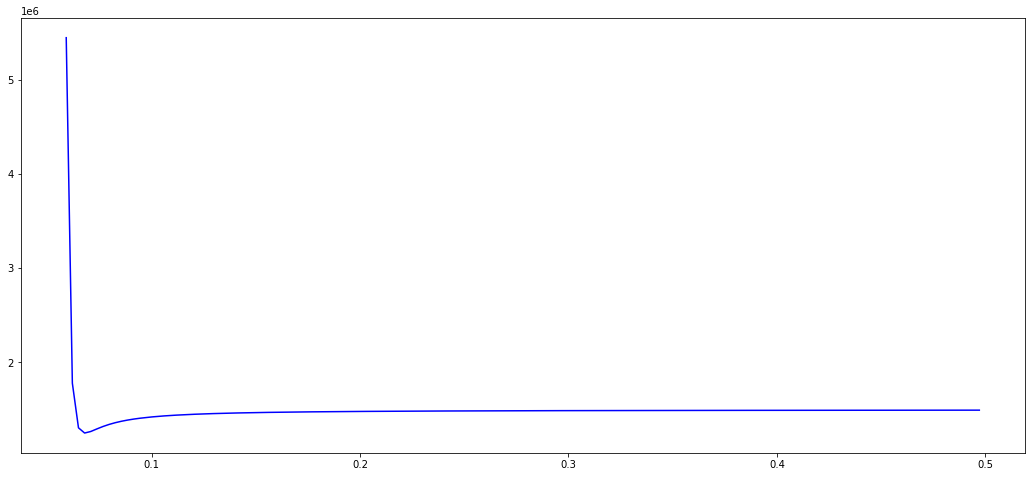

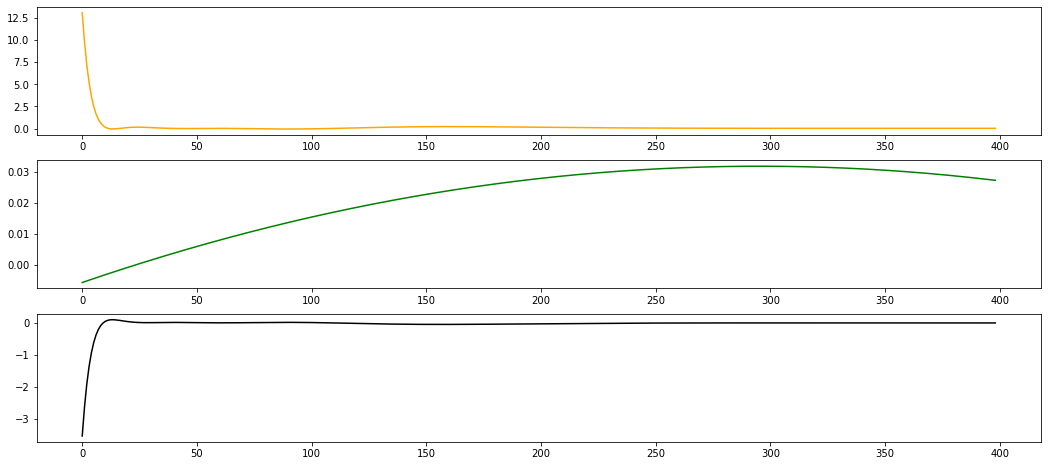

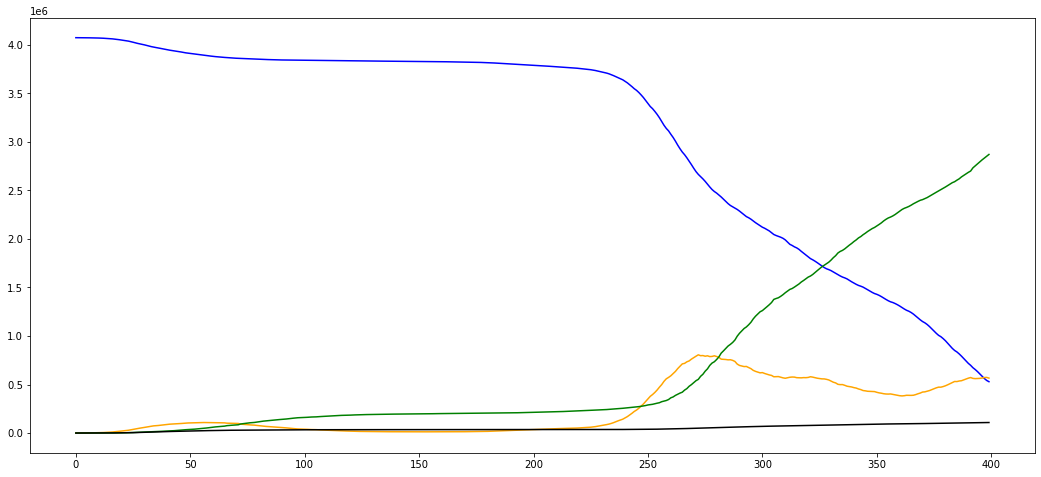

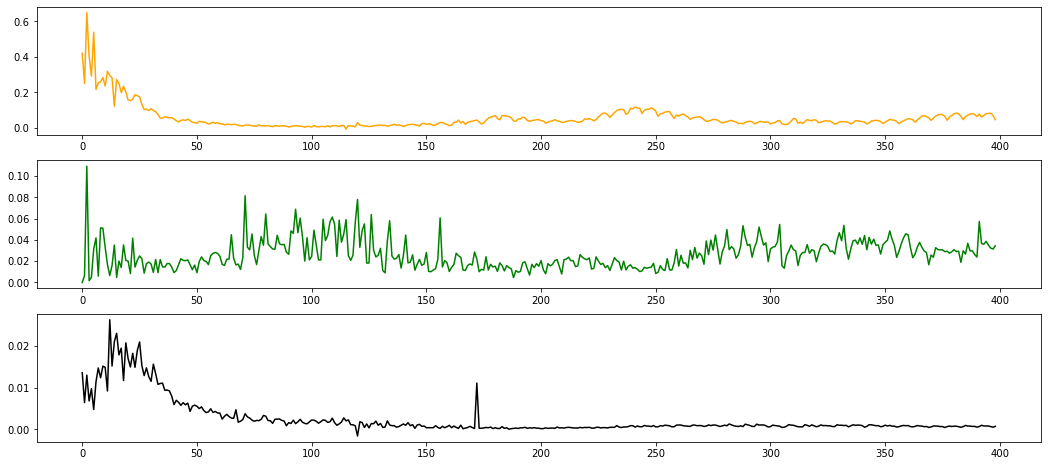

In [14]:
pop = 60000000
numDays = 400
infect = infectRaw[0:numDays]
recov = recovRaw[0:numDays]
dead = deadRaw[0:numDays]
tests = natTested[0:numDays]

q = getQBasis(infect, recov, dead, pop, qMax=.5)

suscept = q*pop - infect - recov - dead
getBasisFunc(suscept, infect, recov, dead)
showCurves(infect, tests, recov, dead, pop, q)
print()

In [6]:
def calculateFutureBasisSmooth(infect, recov, dead, pop, daysToPredict, q=None):
    if(q == None): #calculate q if not set
        q = getQBasis(infect, recov, dead, pop, graph=False)
    
    suscept = q*pop - infect - recov - dead
    
    basisFlat, dtFlat, B, G, M, params = getBasisFunc(suscept, infect, recov, dead, graph=False) #get basis functions
    
    T = len(suscept)
    susceptPredict = np.zeros(T+daysToPredict)
    infectPredict = np.zeros(T+daysToPredict)
    recovPredict = np.zeros(T+daysToPredict)
    deadPredict = np.zeros(T+daysToPredict)
    
    lenB = np.shape(B)[1]
    lenG = np.shape(G)[1]
    lenM = np.shape(M)[1]
    #B = B[0] #B was returned as a function of time, use first element to get correct shape
    #G = G[0] #G was returned as a function of time, use first element to get correct shape
    #M = M[0] #M was returned as a function of time, use first element to get correct shape
    #B[0] = 1 #bias of 1
    #G[0] = 1
    #M[0] = 1
    
    basisIter = np.zeros((4, lenB+lenG+lenM)) #the latest iteration of the large matrix
    dtIter = np.zeros((4,1)) #latest iteration of dt
    
    #copy over known data
    susceptPredict[0:T] = suscept
    infectPredict[0:T] = infect
    recovPredict[0:T] = recov
    deadPredict[0:T] = dead
    
    #fill matrix, then multiply by params to get dt
    for t in range(T - 1, T + daysToPredict - 1):
        
        #fill basis functions using this t
        #for i in range(1,len(B)): #see paper for the basis function used
        #    B[i] = np.exp( -t / (1.05265*i+8.94735))
        #    M[i] = np.exp( -t / (1.05265*i+8.94735))
        #for i in range(1, len(G)):
        #    G[i] = t**i
        
        #set intial value x(t,0)
        #fill row 0
        basisIter[0,0:lenB] = (-(susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])) * B[0]
        basisIter[0,lenB:lenB+lenG] = 0*G[0]
        basisIter[0,lenB+lenG:] = 0*M[0]

        #fill row 1
        basisIter[1,0:lenB] = ((susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])) * B[0]
        basisIter[1,lenB:lenB+lenG] = (-infectPredict[t])*G[0]
        basisIter[1,lenB+lenG:] = (-infectPredict[t])*M[0]

        #fill row 2
        basisIter[2,0:lenB] = 0*B[0]
        basisIter[2,lenB:lenB+lenG] = (infectPredict[t])*G[0]
        basisIter[2,lenB+lenG:] = 0*M[0]

        #fill row 3
        basisIter[3,0:lenB] = 0*B[0]
        basisIter[3,lenB:lenB+lenG] = 0*G[0]
        basisIter[3,lenB+lenG:] = (infectPredict[t])*M[0]


        #find next dtPredict
        dtIter[:,0] = (basisIter @ params)
        #print(params)

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtIter[0,0]
        infectPredict[t+1] = infectPredict[t] + dtIter[1,0]
        recovPredict[t+1] = recovPredict[t] + dtIter[2,0]
        deadPredict[t+1] = deadPredict[t] + dtIter[3,0]
        
        
        for t1 in range(1, T-1):
            #populate the 4x3 matrix with parameters
            #fill row 0
            basisIter[0,0:lenB] = (-(susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])) * B[t1]
            basisIter[0,lenB:lenB+lenG] = 0*G[t1]
            basisIter[0,lenB+lenG:] = 0*M[t1]

            #fill row 1
            basisIter[1,0:lenB] = ((susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])) * B[t1]
            basisIter[1,lenB:lenB+lenG] = (-infectPredict[t])*G[t1]
            basisIter[1,lenB+lenG:] = (-infectPredict[t])*M[t1]

            #fill row 2
            basisIter[2,0:lenB] = 0*B[t1]
            basisIter[2,lenB:lenB+lenG] = (infectPredict[t])*G[t1]
            basisIter[2,lenB+lenG:] = 0*M[t1]

            #fill row 3
            basisIter[3,0:lenB] = 0*B[t1]
            basisIter[3,lenB:lenB+lenG] = 0*G[t1]
            basisIter[3,lenB+lenG:] = (infectPredict[t])*M[t1]


            #find next dtPredict
            dtIter[:,0] = (basisIter @ params)
            #print(params)

            #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
            susceptPredict[t+1] = .5*susceptPredict[t+1] + .5*(susceptPredict[t] + dtIter[0,0])
            infectPredict[t+1] = .5*infectPredict[t+1] + .5*(infectPredict[t] + dtIter[1,0])
            recovPredict[t+1] = .5*recovPredict[t+1] + .5*(recovPredict[t] + dtIter[2,0])
            deadPredict[t+1] = .5*deadPredict[t+1] + .5*(deadPredict[t] + dtIter[3,0])
        
            #print(susceptPredict[t+1] + infectPredict[t+1] + recovPredict[t+1] + deadPredict[t+1])
    
    return susceptPredict, infectPredict, recovPredict, deadPredict, q
    
    #for i in range(daysToPredict):
    #    for t in range(1, T):
    #        susceptPredict[T+i] = .5*susceptPredict[T+i] + .5*susceptPredict[t]
    #        infectPredict[T+i] = .5*infectPredict[T+i] + .5*infectPredict[t]
    #        recovPredict[T+i] = .5*recovPredict[T+i] + .5*recovPredict[t]
    #        deadPredict[T+i] = .5*deadPredict[T+i] + .5*deadPredict[t]
    #
    #
    #return susceptPredict, infectPredict, recovPredict, deadPredict, q

def calculateFutureBasis(infect, recov, dead, pop, daysToPredict, q=None):
    if(q == None): #calculate q if not set
        q = getQBasis(infect, recov, dead, pop, graph=False)
    
    suscept = q*pop - infect - recov - dead
    
    basisFlat, dtFlat, B, G, M, params = getBasisFunc(suscept, infect, recov, dead, graph=False) #get basis functions
    
    T = len(suscept)
    susceptPredict = np.zeros(T+daysToPredict)
    infectPredict = np.zeros(T+daysToPredict)
    recovPredict = np.zeros(T+daysToPredict)
    deadPredict = np.zeros(T+daysToPredict)
    
    lenB = np.shape(B)[1]
    lenG = np.shape(G)[1]
    lenM = np.shape(M)[1]
    #B = B[0] #B was returned as a function of time, use first element to get correct shape
    #G = G[0] #G was returned as a function of time, use first element to get correct shape
    #M = M[0] #M was returned as a function of time, use first element to get correct shape
    #B[0] = 1 #bias of 1
    #G[0] = 1
    #M[0] = 1
    
    basisIter = np.zeros((4, lenB+lenG+lenM)) #the latest iteration of the large matrix
    dtIter = np.zeros((4,1)) #latest iteration of dt
    
    #copy over known data
    susceptPredict[0:T] = suscept
    infectPredict[0:T] = infect
    recovPredict[0:T] = recov
    deadPredict[0:T] = dead
    
    #fill matrix, then multiply by params to get dt
    for t in range(T - 1, T + daysToPredict - 1):
        
        #fill basis functions using this t
        #for i in range(1,len(B)): #see paper for the basis function used
        #    B[i] = np.exp( -t / (1.05265*i+8.94735))
        #    M[i] = np.exp( -t / (1.05265*i+8.94735))
        #for i in range(1, len(G)):
        #    G[i] = t**i
        
        #set intial value x(t,0)
        #fill row 0
        basisIter[0,0:lenB] = (-(susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])) * B[-1]
        basisIter[0,lenB:lenB+lenG] = 0*G[-1]
        basisIter[0,lenB+lenG:] = 0*M[-1]

        #fill row 1
        basisIter[1,0:lenB] = ((susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])) * B[-1]
        basisIter[1,lenB:lenB+lenG] = (-infectPredict[t])*G[-1]
        basisIter[1,lenB+lenG:] = (-infectPredict[t])*M[-1]

        #fill row 2
        basisIter[2,0:lenB] = 0*B[-1]
        basisIter[2,lenB:lenB+lenG] = (infectPredict[t])*G[-1]
        basisIter[2,lenB+lenG:] = 0*M[-1]

        #fill row 3
        basisIter[3,0:lenB] = 0*B[-1]
        basisIter[3,lenB:lenB+lenG] = 0*G[-1]
        basisIter[3,lenB+lenG:] = (infectPredict[t])*M[-1]


        #find next dtPredict
        dtIter[:,0] = (basisIter @ params)
        #print(params)

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtIter[0,0]
        infectPredict[t+1] = infectPredict[t] + dtIter[1,0]
        recovPredict[t+1] = recovPredict[t] + dtIter[2,0]
        deadPredict[t+1] = deadPredict[t] + dtIter[3,0]
    
    return susceptPredict, infectPredict, recovPredict, deadPredict, q
    
#predict future days that are not known
def predictFutureBasis(infect, tests, recov, dead, pop, daysToPredict, qVal=None, smooth=False):
    if(smooth):
        pS, pI, pR, pD, q = calculateFutureBasisSmooth(infect, recov, dead, pop, daysToPredict, q=qVal)
    else:
        pS, pI, pR, pD, q = calculateFutureBasis(infect, recov, dead, pop, daysToPredict, q=qVal)
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(suscept, color='blue', label='suscpetible')
    ax.plot(infect, color='orange', label='infected')
    ax.plot(recov, color='green', label='recovered')
    ax.plot(dead, color='black', label='dead')
    ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    ax.plot(pD, color='black', label='dead', linestyle='dashed')
    
#predict days that are known for testing purposes, predicts the end portion of the given data
def predictMatchBasis(infect, tests, recov, dead, pop, daysToPredict, param=None, qVal=None, smooth=False):
    
    if(smooth):
        pS, pI, pR, pD, q = calculateFutureBasisSmooth(infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], pop, daysToPredict, q=qVal)
    else:
        pS, pI, pR, pD, q = calculateFutureBasis(infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], pop, daysToPredict, q=qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(suscept, color='blue', label='suscpetible')
    ax.plot(infect, color='orange', label='infected')
    ax.plot(recov, color='green', label='recovered')
    ax.plot(dead, color='black', label='dead')
    ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    ax.plot(pD, color='black', label='dead', linestyle='dashed')
    

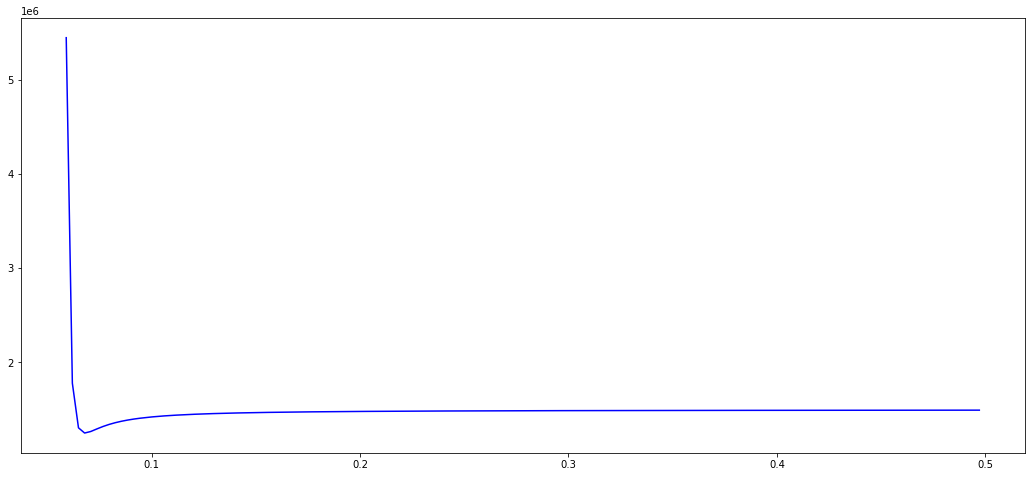

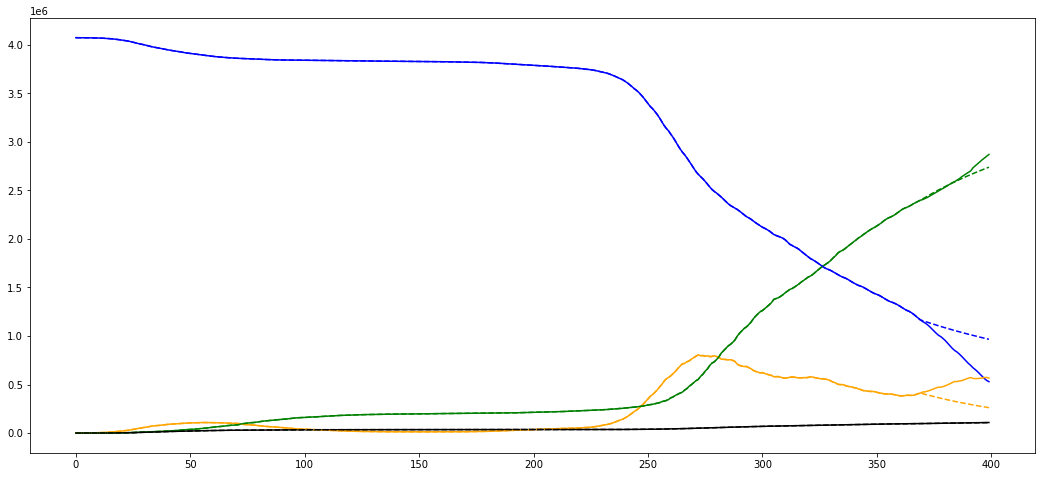

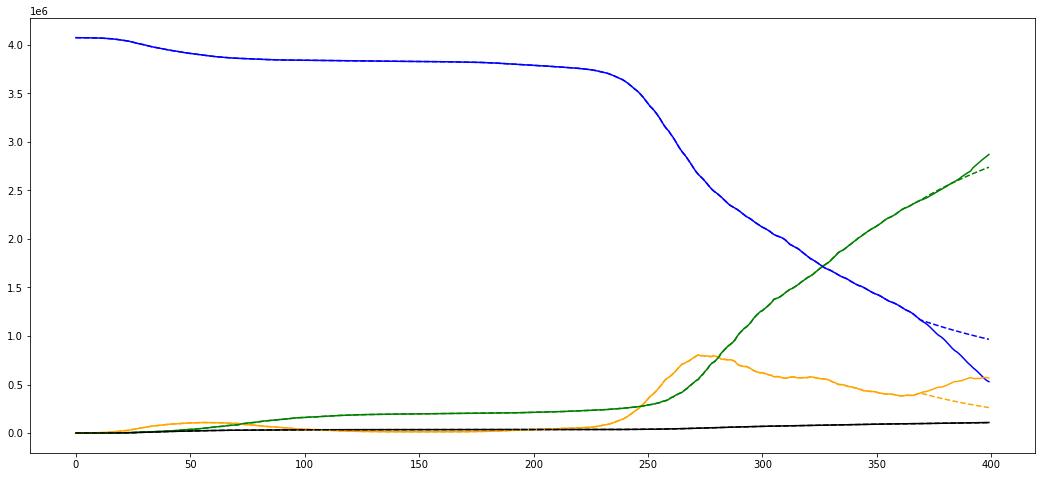

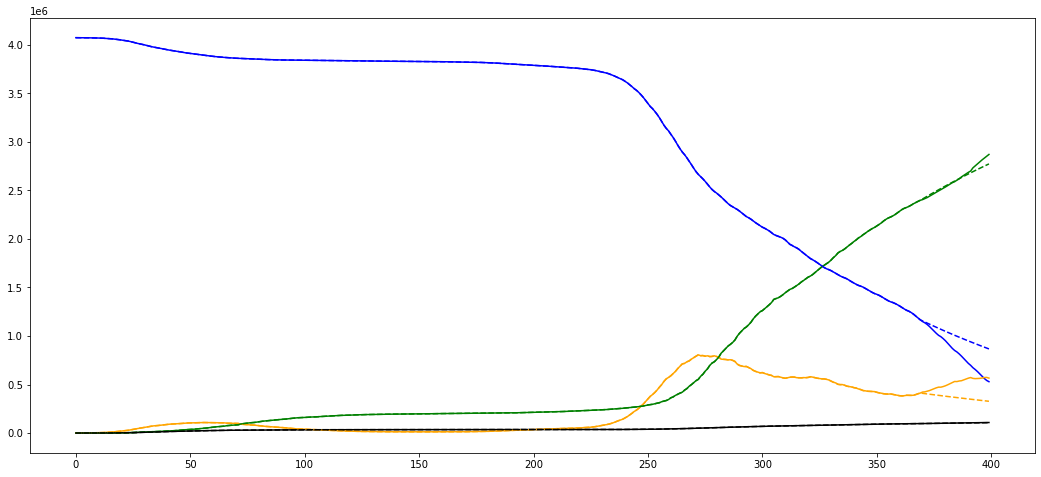

In [15]:
#predict from the paper last 40 days after the first 120
pop = 60000000
numDays = 400
daysToPredict = 30
infect = infectRaw[0:numDays]
recov = recovRaw[0:numDays]
dead = deadRaw[0:numDays]
tests = natTested[0:numDays]

#q=None #use this to have function automatically calculte q
q=.08 #manually set q
q = getQBasis(infect, recov, dead, pop, qMax=.5)
predictMatchBasis(infect, tests, recov, dead, pop, daysToPredict, qVal=q, smooth=False) #print with smoothing method
predictMatchBasis(infect, tests, recov, dead, pop, daysToPredict, qVal=q, smooth=True) #print with smoothing method
predictMatch(infect, tests, recov, dead, pop, daysToPredict, qVal=q)